# Physical activity and sleep notebook:

### Contents:

1. Loading dependencies
2. Processing and extraction

## 1. Loading dependencies

In [46]:
#Package loading
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime, date, time, timedelta

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import rcParams
from matplotlib.dates import DateFormatter
from matplotlib import rc
from matplotlib.dates import date2num
from IPython import display
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.dates as dates
%matplotlib inline

from scipy import stats as sps
from scipy.interpolate import interp1d

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor

import statsmodels.api as sm
from CosinorPy import file_parser, cosinor, cosinor1

import glob
import math
from os import path
from collections import defaultdict
import nolds
import pyActigraphy as pyAc
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14,8)
plt.rcParams['font.size'] = 18
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
plt.rc('font', family='serif')

## 2. Processing and extraction

In [134]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
from preprocessing import Subject

filelist = ['DummyBVS5.csv']#,'dummybbvs_2.csv']#,'dummy2_full.csv']#,'dummy1_full.csv']#,
           # 'dummybbvs_1.csv', 'dummybbvs_2.csv']
quantiles=[0.4]

    
def get_data(filelist):
    d = defaultdict(dict)
    for idx, filename in enumerate(filelist):
        d[idx] = Subject(filename)
        d[idx].get_METS()
        #d[idx].get_HRV()
        d[idx].get_PA()
        d[idx].get_sleep_grid(q_sleep=quantiles, bed_time = '20:00',wake_time = '12:00', seq_length = 15)
        #d[idx].get_windows()
        #d[idx].get_SRI(q_sleep=quantiles)
        #d[idx].get_ARI()
        #d[idx].get_cosinor()
        #d[idx].get_SSA()
        #d[idx].get_nonlinear()
        #d[idx].Crespo(zeta=15, zeta_r=50, zeta_a=2,t=.50, alpha='7h', beta='1h',
        #              estimate_zeta=False, seq_length_max=100, verbose=False)
        #Depends on running METS,PA,sleep, windows, SRI, first
        #d[idx].get_daily_stats()
    return d

d = get_data(filelist)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
def get_vanhees(self, limb = 'dw',q_sleep=0.1, bed_time = '20:00',wake_time = '12:00', min_len = 30, gaps=60, factor=15):
    if all(self.data.ts.diff()[1:] == np.timedelta64(60, 's')) == False:
        vhees= self.data.resample('1T').mean().copy()
    else:
        vhees = self.data.copy()
    day_start = '08:00'
    #day_end = '23:00'
    col_sleep = 'sleep'
    col_wake = 'wake'
    #Base is read from function input and start of day
    base_s = int(bed_time[0:2])
    base_w = int(day_start[0:2])
    sleep_rec = defaultdict(dict)
    if hasattr(self,'sleep_recvh')==0:
        self.sleep_recvh=sleep_rec
    
    def get_threshold_bins(vhees, col_apply, col_new, base_w,quantile):
        vhees[col_apply+'_diff'] = vhees[col_apply].diff().abs()
        vhees[col_apply+'_5mm'] = vhees[col_apply+'_diff'].rolling(5).median()
        vhees[col_apply+'_10pct'] = vhees[col_apply+'_5mm'].resample('24H',base=base_w).apply(lambda x: np.quantile(x,q_sleep))
        vhees[col_apply+'_10pct'] = vhees[col_apply+'_10pct'].ffill(axis=0)
        vhees[col_apply+'_10pct'] = vhees[col_apply+'_10pct'].fillna(method='bfill')
        vhees[col_apply+'_bin'] =np.where((vhees[col_apply+'_5mm']-vhees[col_apply+'_10pct']*factor)>0, 0, 1)
        
        vhees[col_apply+'_seq_id'] = vhees.groupby((vhees[col_apply+'_bin'] != 
                                                            vhees[col_apply+'_bin'].shift(1).fillna(False)).cumsum()).ngroup()
        vhees[col_apply+'_len'] = 0
        vhees[col_apply+'_len'] = vhees[[col_apply+'_len', col_apply+'_seq_id']].groupby(col_apply+'_seq_id').transform('count')
        return vhees
    
    def get_sleep_windows(df,data,limb,night_count,cols, base_w, base_s,min_len):
        for col_apply in cols:
            df[col_apply+'_labels'] = (df[col_apply+'_bin']==1.0) & (df[col_apply+'_len'] > min_len).astype(int)
            df[col_apply+'_gaps'] = (df[col_apply+'_bin']==0.0) & (df[col_apply+'_len'] > gaps).astype(int)
            df[col_apply+'_labels_2'] = ((df[col_apply+'_labels']==1.0) & (df[col_apply+'_gaps']==0.0)).astype(int)
        df['sleepvote_'+limb] = ((df[cols[0]+'_labels_2']==1.0) & (df[cols[1]+'_labels_2']==1.0)).astype(int)
        #Extract the times when labelled sleep changes to wake and viceversa
        state_changes = df['sleepvote_'+limb].diff().fillna(0)[lambda x: x != 0].index.tolist()
        state_changes = pd.to_datetime(state_changes).to_frame()
        #Extract index of nights available for the subject to pass onto sleep df
        index = state_changes.resample('24H',base=base_s).min().index
        sleep_df = pd.DataFrame(columns=['TST','sleep_onset','sleep_offset','weekday'], index = index)
        #Extract sleep onset each night as earliest wake-sleep transition after base hour
        sleep_df['sleep_onset'] = state_changes.resample('24H',base=base_s).min()
        #Extract sleep onset each night as last sleep-wake transition after base hour
        sleep_df['sleep_offset'] = state_changes.resample('24H',base=base_s).max()
        sleep_df['TST']= sleep_df['sleep_offset'] -  sleep_df['sleep_onset']
        sleep_df['weekday'] = sleep_df.index.dayofweek
        sleep_df = pd.DataFrame(sleep_df)
        #Label sleep windows on original df according to sleep_df
        df['sleep_window_'+limb] = np.nan
        sleep_df = sleep_df.dropna()
        #Keep only nights with enough data (more than 8 hours available in the interval)
        sleep_df = sleep_df[night_count > 480]
        print(sleep_df)
        df['sleep_window_'+limb].loc[sleep_df['sleep_onset']] = 1
        df['sleep_window_'+limb].loc[sleep_df['sleep_offset']] = 0
        df['sleep_window_'+limb] = df['sleep_window_'+limb].fillna(method='ffill')
        data['sleep_window_'+limb] = df['sleep_window_'+limb]
        data['sleep_window_'+limb] = data['sleep_window_'+limb].fillna(method='ffill')
        return df, state_changes, sleep_df, index,data

    #Execute functions
    get_threshold_bins(vhees,'pitch_mean_'+limb,col_sleep, base_w, quantile=q_sleep)
    get_threshold_bins(vhees,'roll_mean_'+limb,col_sleep, base_w, quantile=q_sleep)

    night = vhees.between_time(bed_time,wake_time, include_start = True, 
                                            include_end = True)
    night_count = night['pitch_mean_'+limb].resample('24H',base=base_s).count()
    
    night, state_changes, sleep_df, index,vhees= get_sleep_windows(night,
                                                                       vhees,limb,night_count,['pitch_mean_'+limb,'roll_mean_'+limb],
                                                                       base_w,base_s,min_len)
    #night, state_changes_r, sleep_df_r, index,vhees = get_sleep_windows(night,vhees,limb,night_count,'roll_mean_'+limb, base_w,base_s,min_len)
       
    #fig, ax = plt.subplots(2,1,figsize=(20,15))
    #ax[0].plot(vhees.pitch_mean_dw)
    #ax[0].plot(vhees['pitch_mean_dw'+'_labels_2']*10, color='black', label='labels')
    #ax[0].plot(vhees['pitch_mean_dw'+'_window']*20, color='green', label='sleep')
    #ax[0].plot(vhees['pitch_mean_dw'+'_gaps']*-10, color='red', label='gaps')
    
    #ax[1].plot(vhees.roll_mean_dw)
    #ax[1].plot(vhees['roll_mean_dw'+'_labels_2']*10, color='black', label='labels')
    #ax[1].plot(vhees['roll_mean_dw'+'_window']*20, color='green', label='sleep')
    #ax[1].plot(vhees['roll_mean_dw'+'_gaps']*-10, color='red', label='gaps')
    #plt.legend()
    #plt.show()
    
    #Extract sleep efficiency as (TST-WASO)/TST
    sleep_TST_delta = [(x.seconds/60) for x in sleep_df['TST'] ] 
    #sleep_TST_delta_r = [(x.seconds/60) for x in sleep_df_r['TST'] ] 
            
    self.data['sleep_window_'+limb] = vhees['sleep_window_'+limb]
    
    self.sleep_recvh[limb] = sleep_df
            
    return self

get_vanhees(d[0], limb='dw',q_sleep=0.10, bed_time = '20:00',wake_time = '12:00',min_len = 20, gaps=60, factor=15)
get_vanhees(d[0], limb='ndw',q_sleep=0.10, bed_time = '20:00',wake_time = '12:00',min_len = 20, gaps=60, factor=15)
get_vanhees(d[0], limb='thigh',q_sleep=0.10, bed_time = '20:00',wake_time = '12:00',min_len = 20, gaps=60, factor=15)

                         TST         sleep_onset        sleep_offset  weekday
2016-01-12 20:00:00 07:53:00 2016-01-12 22:47:00 2016-01-13 06:40:00        1
2016-01-13 20:00:00 05:34:00 2016-01-13 23:14:00 2016-01-14 04:48:00        2
2016-01-14 20:00:00 06:16:00 2016-01-14 22:58:00 2016-01-15 05:14:00        3
2016-01-15 20:00:00 06:32:00 2016-01-16 01:13:00 2016-01-16 07:45:00        4
2016-01-16 20:00:00 04:51:00 2016-01-17 02:03:00 2016-01-17 06:54:00        5
2016-01-17 20:00:00 07:42:00 2016-01-17 22:37:00 2016-01-18 06:19:00        6
2016-01-18 20:00:00 05:29:00 2016-01-18 22:48:00 2016-01-19 04:17:00        0
2016-01-19 20:00:00 06:01:00 2016-01-19 23:04:00 2016-01-20 05:05:00        1
2016-01-20 20:00:00 08:14:00 2016-01-20 22:29:00 2016-01-21 06:43:00        2
                         TST         sleep_onset        sleep_offset  weekday
2016-01-12 20:00:00 07:57:00 2016-01-12 22:43:00 2016-01-13 06:40:00        1
2016-01-13 20:00:00 05:31:00 2016-01-13 23:14:00 2016-01-14 04:4

In [137]:
#Read diary (specific for the dummyBVS5 participant, some data extraction idiosyncrasies)
diaries = pd.read_csv('Data/dummydiaries.csv',index_col='id',header=0)
diaries_t = diaries.transpose().reset_index().rename(columns={'index':'var'})
diary5 = pd.to_datetime(diaries_t['DummyBVS5'].drop([0,1]).dropna())
#diary5 = pd.to_datetime(diaries_t['DummyBVS5'].dropna())
#print(diary5)
diary_sleep = [] 
diary_wake = [] 
for i in range(len(diary5)): 
    if i % 2: 
        diary_wake.append(diary5[i+2]) 
    else : 
        diary_sleep.append(diary5[i+2])
df_diary5 = pd.DataFrame(data={'sleep_onset':pd.Series(diary_sleep),'sleep_offset':pd.Series(diary_wake)})
df_diary5['sleep_onset'][0] = '2016-01-12 22:35:00'
#print(df_diary5)

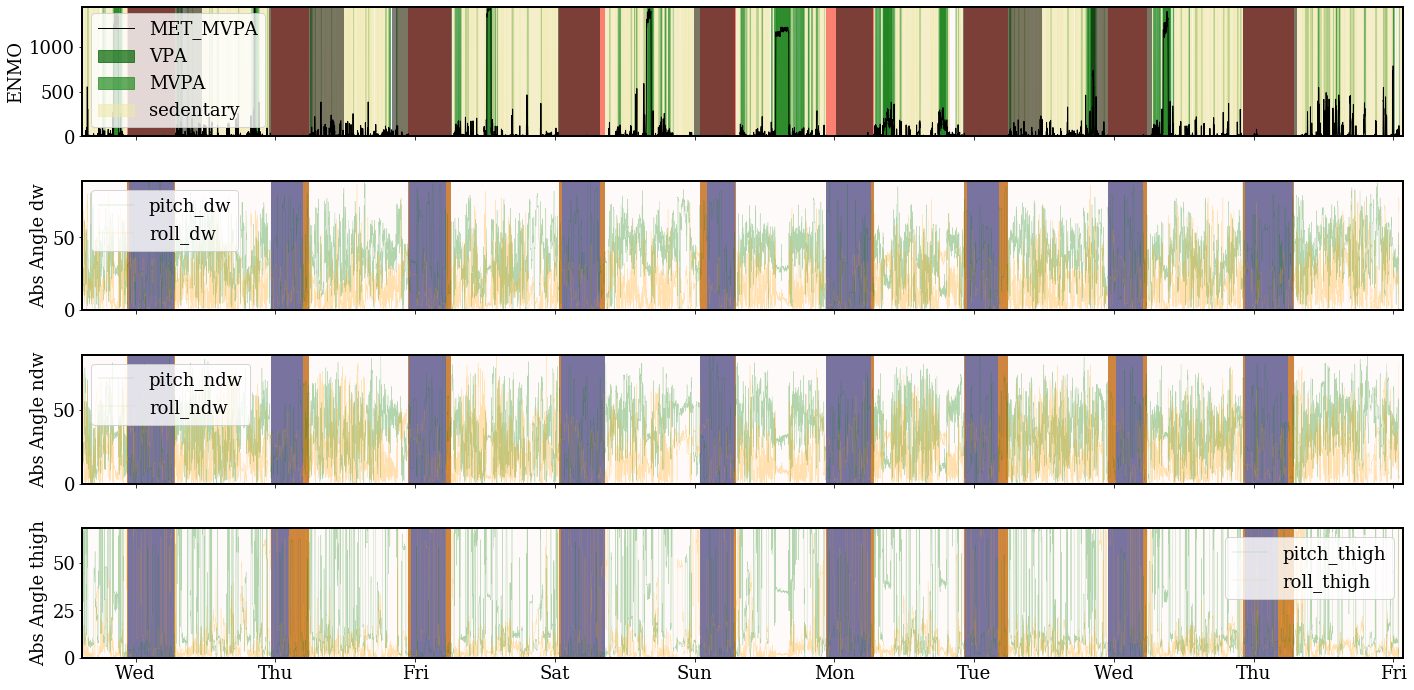

In [142]:
#%load_ext autoreload
#%autoreload 2
#warnings.filterwarnings('ignore')

def plot_algos(d,i,diary):
    fig, ax1 = plt.subplots(4, 1, figsize= (20, 10),sharex=True)
    #ax1.set_title("Physical activity and sedentary time per hour")                        
    #Resampling: hourly
    df2_h = d[i].data.copy()#resample(frequency).sum()
    ax1[0].set_ylim(0,max(df2_h['ENMO']))
    ax1[0].set_facecolor('snow')
    ax1[0].plot(df2_h.index,df2_h['ENMO'], label='MET_MVPA',linewidth=1, color ='black',alpha=1)
    ax1[0].fill_between(df2_h.index, 0, df2_h['min_VigPA']*1500,facecolor ='darkgreen',alpha=0.7, label='VPA',edgecolor='darkgreen')
    ax1[0].fill_between(df2_h.index, 0, df2_h['min_MVPA']*1500,facecolor ='forestgreen',alpha=0.7, label='MVPA',edgecolor='forestgreen')
    ax1[0].fill_between(df2_h.index, 0, (df2_h['MET_Sed'])*1500,facecolor ='palegoldenrod',alpha=0.6,label='sedentary',edgecolor='palegoldenrod')
    ax1[0].set_ylabel('ENMO')
    ax1[0].set_xticks([])
    ax1[0].legend()  
    #Add grey windows for sleep
    for idx in range(len(diary)):
        ax1[0].axvspan(diary['sleep_onset'][idx],diary['sleep_offset'][idx],facecolor='salmon',alpha=1) 
    for idx in range(len(d[i].sleep_rec[0.4])):
        ax1[0].axvspan(d[i].sleep_rec[0.4]['sleep_onset'][idx],d[i].sleep_rec[0.4]['sleep_offset'][idx],facecolor='black',alpha=0.5) 
 
    
    ax1[1].plot(df2_h.index,df2_h['pitch_mean_dw'].abs(), label='pitch_dw',linewidth=0.4, color ='green',alpha=0.3)
    ax1[1].plot(df2_h.index,df2_h['roll_mean_dw'].abs(), label='roll_dw',linewidth=0.4, color ='orange',alpha=0.3)
    ax1[1].set_xticks([])
    ax1[1].set_ylabel('Abs Angle dw')
    ax1[1].set_facecolor('snow')
    ax1[1].set_ylim(0,max(df2_h['pitch_mean_dw']))
    ax1[2].plot(df2_h.index,df2_h['pitch_mean_ndw'].abs(), label='pitch_ndw',linewidth=0.4, color ='green',alpha=0.3)
    ax1[2].plot(df2_h.index,df2_h['roll_mean_ndw'].abs(), label='roll_ndw',linewidth=0.4, color ='orange',alpha=0.3)
    ax1[2].set_xticks([])
     
    ax1[2].set_facecolor('snow')
    ax1[2].set_ylabel('Abs Angle ndw')
    ax1[2].set_ylim(0,max(df2_h['pitch_mean_ndw']))
    ax1[3].plot(df2_h.index,df2_h['pitch_mean_thigh'].abs(), label='pitch_thigh',linewidth=0.4, color ='green',alpha=0.3)
    ax1[3].plot(df2_h.index,df2_h['roll_mean_thigh'].abs(), label='roll_thigh',linewidth=0.4, color ='orange',alpha=0.3)
    
    ax1[3].set_facecolor('snow')
    ax1[3].set_ylabel('Abs Angle thigh')
    ax1[3].set_ylim(0,max(df2_h['pitch_mean_thigh']))
    
    for jdx in range(1,4):
        for idx in range(len(diary)):
            ax1[jdx].axvspan(diary['sleep_onset'][idx],diary['sleep_offset'][idx],facecolor='peru',alpha=1) 
    for idx in range(len(d[i].sleep_recvh['dw'])):
        ax1[1].axvspan(d[i].sleep_recvh['dw']['sleep_onset'][idx],d[i].sleep_recvh['dw']['sleep_offset'][idx],facecolor='royalblue',alpha=0.6)
    for idx in range(len(d[i].sleep_recvh['ndw'])):
        ax1[2].axvspan(d[i].sleep_recvh['ndw']['sleep_onset'][idx],d[i].sleep_recvh['ndw']['sleep_offset'][idx],facecolor='royalblue',alpha=0.6)
    for idx in range(len(d[i].sleep_recvh['dw'])):
        ax1[3].axvspan(d[i].sleep_recvh['thigh']['sleep_onset'][idx],d[i].sleep_recvh['thigh']['sleep_offset'][idx],facecolor='royalblue',alpha=0.6)
    
    #ax1[-1].xaxis.set_minor_locator(dates.HourLocator(interval=4))   # every 4 hours
    #ax1[-1].xaxis.set_minor_formatter(dates.DateFormatter('%a'))
    ax1[-1].xaxis.set_major_locator(dates.DayLocator(interval=1))    # every day
    ax1[-1].xaxis.set_major_formatter(dates.DateFormatter('%a'))
    plt.setp(ax1, xlim=(df2_h.index[0],df2_h.index[-1]))
    ax1[0].legend()
    ax1[1].legend()
    ax1[2].legend()
    ax1[3].legend()
    #fig.legend()
    plt.tight_layout()
    return fig 

    
f = plot_algos(d,0,df_diary5)
f.savefig('AlgosDiaryPlot.png')
plt.show(f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 1008x576 with 0 Axes>

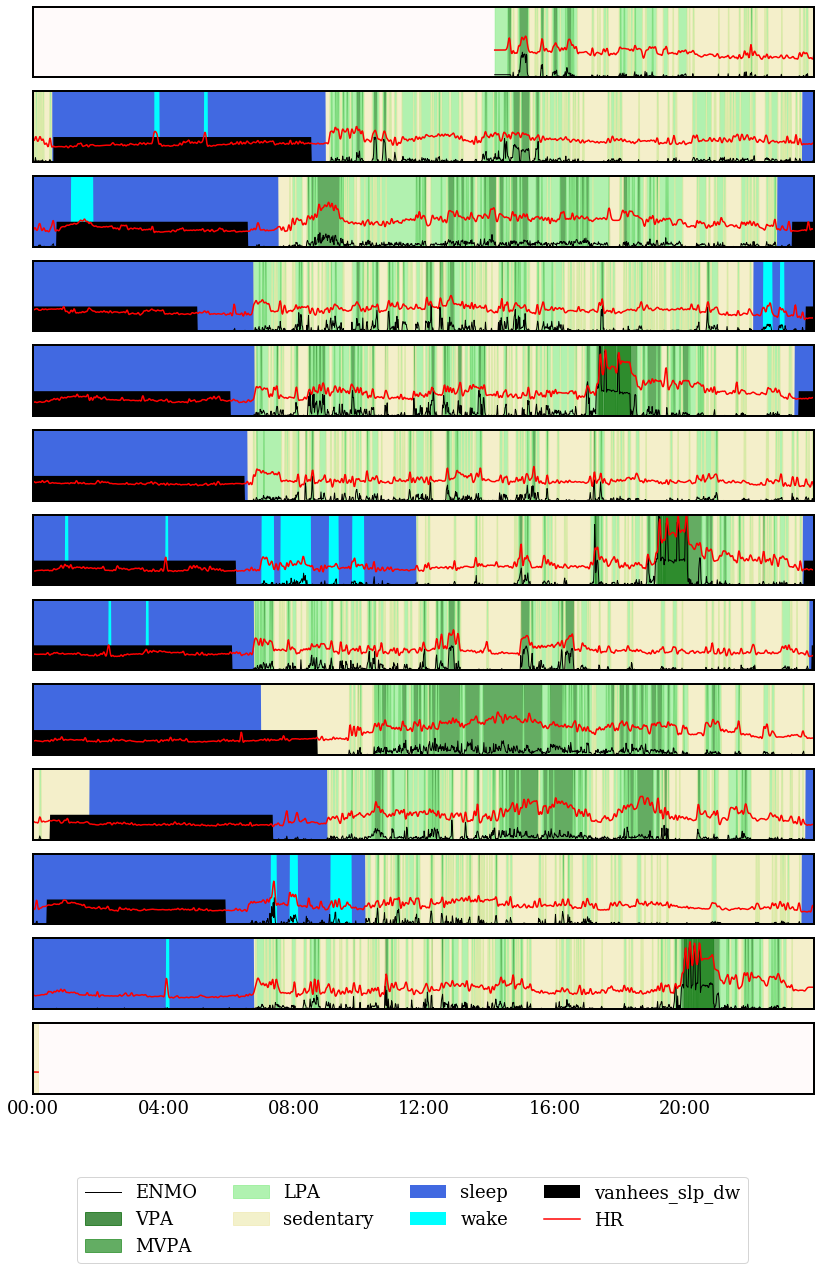

<Figure size 1008x576 with 0 Axes>

In [12]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

def plot_daily_vh(d,i):
    import matplotlib.dates as dates
    DFList = [pd.DataFrame(group[1]) for group in d[i].data.groupby(d[i].data.index.day)]
    fig, ax1 = plt.subplots(len(DFList), 1, figsize= (14, 20))
    #ax1.set_title("Physical activity and sedentary time per hour")                        
    for idx in range(len(DFList)):
        #Resampling: hourly
        df2_h = DFList[idx]
        ax1[idx].tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=True, rotation=0)
        ax1[idx].set_facecolor('snow')
        #ax1[idx].set_xlabel('Time')
        ax1[idx].set_ylim(0,max(d[i].data['ENMO']/10))
        ax1[idx].set_xlim(DFList[idx].index[0] - timedelta(hours=DFList[idx].index[0].hour) - 
                          timedelta(minutes=DFList[idx].index[0].minute) - timedelta(seconds=DFList[idx].index[0].second), 
                          DFList[idx].index[0] - timedelta(hours=DFList[idx].index[0].hour) - 
                          timedelta(minutes=DFList[idx].index[0].minute) - timedelta(seconds=DFList[idx].index[0].second) +
                          timedelta(minutes=1439))

        ax1[idx].plot(df2_h.index, df2_h['ENMO']/10,label='ENMO', linewidth=1, color ='black',alpha=1)
        ax1[idx].fill_between(df2_h.index, 0, df2_h['min_VigPA']*200,facecolor ='darkgreen',alpha=0.7, label='VPA',edgecolor='darkgreen')
        ax1[idx].fill_between(df2_h.index, 0, df2_h['min_MVPA']*200,facecolor ='forestgreen',alpha=0.7, label='MVPA',edgecolor='forestgreen')
        
        ax1[idx].fill_between(df2_h.index, 0, df2_h['min_LPA']*200,facecolor ='lightgreen',alpha=0.7, label='LPA',edgecolor='lightgreen')
        ax1[idx].fill_between(df2_h.index, 0, (df2_h['MET_Sed'])*200,facecolor ='palegoldenrod',alpha=0.6,label='sedentary',edgecolor='palegoldenrod')
        ax1[idx].fill_between(df2_h.index, 0, -(df2_h['sleep_window_0.4']-2)*200,facecolor ='royalblue',alpha=1,label='sleep')
        ax1[idx].fill_between(df2_h.index, 0, (df2_h['wake_window_0.4'])*200,facecolor ='cyan',alpha=1,label='wake')
        
        ax1[idx].fill_between(df2_h.index, 0, (df2_h['sleep_window_'+'dw'])*50,facecolor ='black',alpha=1,label='vanhees_slp_dw')
        #ax1[idx].fill_between(df2_h.index, 0, (df2_h['sleep_window_'+'roll_dw'])*25,facecolor ='grey',alpha=1,label='vanhees_roll_slp')
        #ax1[idx].fill_between(df2_h.index, 0, (1-df2_h['crespo'])*10,facecolor ='cyan',alpha=0.1,label='crespo_rest')
        
        ax1[idx].set_xticks([])
        ax1[idx].set_yticks([])
    #    for ax in ax_row:
        # create a twin of the axis that shares the x-axis
        ax2 = ax1[idx].twinx()
        #ax2.set_ylabel('mean_HR')  # we already handled the x-label with ax1
        ax2.plot(df2_h.index, df2_h['mean_hr'],label='HR', color='red')
        ax2.set_ylim(30,max(d[i].data['mean_hr']))
        ax2.set_xticks([])
        ax2.set_yticks([])
              
    ax1[-1].xaxis.set_minor_locator(dates.HourLocator(interval=4))   # every 4 hours
    ax1[-1].xaxis.set_minor_formatter(dates.DateFormatter('%H:%M')) # hours and minutes
    #ax1[-1].xaxis.set_major_locator(dates.DayLocator(interval=2))    # every day
    #ax1[-1].xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%Y'))

    handles, labels = ax1[-1].get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(handles+handles2, labels+labels2, loc='lower center',ncol=4)
    return fig


plt.clf()
f = plot_daily_vh(d,0)
#f.savefig('subject_plot.png')
plt.show(f)
plt.clf()